# **Node2Vec Based Graph Convolutional Network**

Uploading Dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fashion-product-images-small.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close

Importing required libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
;import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
articles = pd.read_csv("/content/myntradataset/styles.csv", on_bad_lines='skip')
articles = articles.sort_values(by='id', ascending=True)
articles_sample = articles.head(3000)

In [ ]:
item_name_mapping = dict(zip(articles_sample['id'], articles['productDisplayName']))

Encoding

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
articles_sample['gender'] = label_encoder.fit_transform(articles_sample['gender'])
articles_sample[ 'baseColour'] = label_encoder.fit_transform(articles_sample['baseColour'])
articles_sample[ 'articleType'] = label_encoder.fit_transform(articles_sample['articleType'])

<ipython-input-10-2c67411d80a5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_sample['gender'] = label_encoder.fit_transform(articles_sample['gender'])
<ipython-input-10-2c67411d80a5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_sample[ 'baseColour'] = label_encoder.fit_transform(articles_sample['baseColour'])
<ipython-input-10-2c67411d80a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Creating the graph

In [ ]:
import pandas as pd
import networkx as nx
from itertools import combinations

article_attributes = {}
for index, row in articles_sample.iterrows():
    article_id = row['id']
    attributes = set(row[['gender', 'baseColour', 'articleType']])
    article_attributes[article_id] = attributes

G = nx.Graph()


for (article1, attr1), (article2, attr2) in combinations(article_attributes.items(), 2):
    similarity = len(attr1.intersection(attr2)) / len(attr1.union(attr2))
    if similarity > 0:
        G.add_edge(article1, article2, weight=similarity)

In [ ]:
def biased_random_walk(G, start_node, walk_length, p=1, q=1):
    walk = [start_node]

    while len(walk) < walk_length:
        cur_node = walk[-1]
        cur_neighbors = list(G.neighbors(cur_node))

        if len(cur_neighbors) > 0:
            if len(walk) == 1:
                walk.append(random.choice(cur_neighbors))
            else:
                prev_node = walk[-2]

                probability = []
                for neighbor in cur_neighbors:
                    if neighbor == prev_node:
                        # Return parameter
                        probability.append(1/p)
                    elif G.has_edge(neighbor, prev_node):
                        # Stay parameter
                        probability.append(1)
                    else:
                        # In-out parameter
                        probability.append(1/q)

                probability = np.array(probability)
                probability = probability / probability.sum()  # normalize

                next_node = np.random.choice(cur_neighbors, p=probability)
                walk.append(next_node)
        else:
            break

    return walk

In [ ]:
def generate_walks(G, num_walks, walk_length, p=1, q=1):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walk_from_node = biased_random_walk(G, node, walk_length, p, q)
            walks.append(walk_from_node)
    return walks

Generating Embeddings using Node2Vec

In [ ]:
walks = generate_walks(G, num_walks=10, walk_length=20, p=9, q=1)
filtered_walks = [walk for walk in walks if len(walk) >= 5]
walks = [[str(node) for node in walk] for walk in walks]
model = Word2Vec(walks, vector_size=128, window=5, min_count=0,  hs=1, sg=1, workers=4, epochs=10)
embeddings = {node_id: model.wv[node_id] for node_id in model.wv.index_to_key}


In [ ]:
import pickle

Saving the embeddings

In [ ]:
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

In [ ]:
with open('/content/embeddings3K.pkl', 'rb') as f:
    embeddings=pickle.load(f)

Show Images Function

In [ ]:
def show_images(items, item_name_mapping, num_items, show_similarity=False):
    f, ax = plt.subplots(1, num_items, figsize=(5,5))
    if num_items == 1:
        ax = [ax]
    for i, item in enumerate(items):
        item_id, similarity = item
        # print(f"- Item {item_id}: {item_name_mapping[item_id]}", end='')
        # if show_similarity:
        #     print(f" with similarity score: {similarity}")
        # else:
        #     print()
        img_path = f"/content/myntradataset/images/{int(item_id)}.jpg"
        try:
            img = mpimg.imread(img_path)
            ax[i].imshow(img)
            ax[i].set_title(f'Item {item_id}')
            ax[i].set_xticks([], [])
            ax[i].set_yticks([], [])
            ax[i].grid(False)
        except FileNotFoundError:
            print(f"Image for item {item_id} not found.")
    plt.show()

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:00


Converting Graph to PyTorch Geometric Data

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
data = from_networkx(G)
node_features = np.array([embeddings[str(node)] for node in G.nodes])
data.x = torch.tensor(node_features, dtype=torch.float)

Model Initialization and Training

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 128)
        self.conv2 = GCNConv(128,128)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GCN(num_node_features=node_features.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.x)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.0503493994474411
Epoch 2, Loss: 0.0464714877307415
Epoch 3, Loss: 0.04485059157013893
Epoch 4, Loss: 0.044296614825725555
Epoch 5, Loss: 0.04392652213573456
Epoch 6, Loss: 0.043726954609155655
Epoch 7, Loss: 0.043583255261182785
Epoch 8, Loss: 0.04345916584134102
Epoch 9, Loss: 0.04330522567033768
Epoch 10, Loss: 0.04312825947999954
Epoch 11, Loss: 0.042940374463796616
Epoch 12, Loss: 0.042753804475069046
Epoch 13, Loss: 0.04257398843765259
Epoch 14, Loss: 0.04241705685853958
Epoch 15, Loss: 0.042288728058338165
Epoch 16, Loss: 0.042180318385362625
Epoch 17, Loss: 0.042086221277713776
Epoch 18, Loss: 0.042006831616163254
Epoch 19, Loss: 0.04194120317697525
Epoch 20, Loss: 0.041879527270793915
Epoch 21, Loss: 0.04181978479027748
Epoch 22, Loss: 0.041760873049497604
Epoch 23, Loss: 0.04170261695981026
Epoch 24, Loss: 0.04164186492562294
Epoch 25, Loss: 0.04157904163002968
Epoch 26, Loss: 0.04151388630270958
Epoch 27, Loss: 0.04144786298274994
Epoch 28, Loss: 0.0413788184

Saving the model

In [ ]:
import torch
torch.save(model.state_dict(), 'gcn_model.pth')
torch.save(optimizer.state_dict(), 'optimizer.pth')


In [ ]:
import torch
model = GCN(num_node_features=node_features.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.load_state_dict(torch.load('gcn_model.pth'))
optimizer.load_state_dict(torch.load('optimizer.pth'))
model.eval()


GCN(
  (conv1): GCNConv(128, 128)
  (conv2): GCNConv(128, 128)
)

In [ ]:
model.eval()
with torch.no_grad():
    new_embeddings = model(data)

GCN(
  (conv1): GCNConv(128, 128)
  (conv2): GCNConv(128, 128)
)

Recommending Items

Similar articles to 2098:

Recommended items for article 2098:


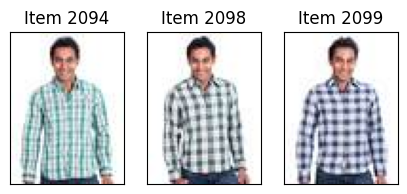

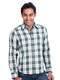

In [ ]:

def calculate_new_similarities(id, df, new_embeddings, article_id_mapping):
    rated_items = set(df['id'])
    article_embedding = new_embeddings[article_id_mapping[id]].numpy()


    item_similarities = []
    for item_id in set(df['id']):
        if item_id  in rated_items:
            item_embedding = new_embeddings[article_id_mapping[item_id]].numpy()
            similarity = cosine_similarity([article_embedding], [item_embedding])[0][0]
            item_similarities.append((item_id, similarity))


    return item_similarities

def recommend_new_items(id, df, new_embeddings, item_name_mapping, article_id_mapping, num_items=5):
    rated_items = set(df['id'])

    print(f"Similar articles to {id}:")

    item_similarities = calculate_new_similarities(id, df, new_embeddings, article_id_mapping)

    recommended_items = sorted(item_similarities, key=lambda x: x[1], reverse=True)[:num_items]


    print(f"\nRecommended items for article {id}:")
    show_images(recommended_items, item_name_mapping, num_items, show_similarity=True)


article_id_mapping = {id: i for i, id in enumerate(G.nodes) if str(id).isdigit()}

recommend_new_items(2098, articles_sample, new_embeddings, item_name_mapping, article_id_mapping, num_items=3)
input_image="/content/images/2098.jpg"
from IPython.display import Image
Image(input_image)


Calculating Accuracy

In [ ]:
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(embedding1, embedding2):
    return cosine_similarity([embedding1], [embedding2])[0][0]

def process_folders(manual_base_path, model_base_path, num_folders, new_embeddings, article_id_mapping):
    similarities = []


    for i in range(1, num_folders + 1):
        manual_folder = os.path.join(manual_base_path, f'test{i}_manual')
        model_folder = os.path.join(model_base_path, f'test{i}_rec')


        manual_images = sorted(os.listdir(manual_folder))
        model_images = sorted(os.listdir(model_folder))

        folder_similarities = []

        for man_img, mod_img in zip(manual_images, model_images):

            man_article_id = int(os.path.splitext(man_img)[0])
            mod_article_id = int(os.path.splitext(mod_img)[0])


            man_embedding = new_embeddings[article_id_mapping[man_article_id]].numpy()
            mod_embedding = new_embeddings[article_id_mapping[mod_article_id]].numpy()


            similarity = compute_similarity(man_embedding, mod_embedding)
            folder_similarities.append((f'manrec{i}/{man_img}', f'rec{i}/{mod_img}', similarity))


        similarities.extend(folder_similarities)

    return similarities

manual_base_path = '/content/drive/MyDrive/Manual'
model_base_path = '/content/drive/MyDrive/Model'
num_folders = 22

similarities = process_folders(manual_base_path, model_base_path, num_folders, new_embeddings, article_id_mapping)


df = pd.DataFrame(similarities, columns=['Manual Image', 'Model Image', 'Similarity'])
df.to_csv('image_similarities.csv', index=False)
mean_similarity = df['Similarity'].mean()

print(f"\nMean Similarity: {mean_similarity}")



Mean Similarity: 0.9558110237121582


Visualization

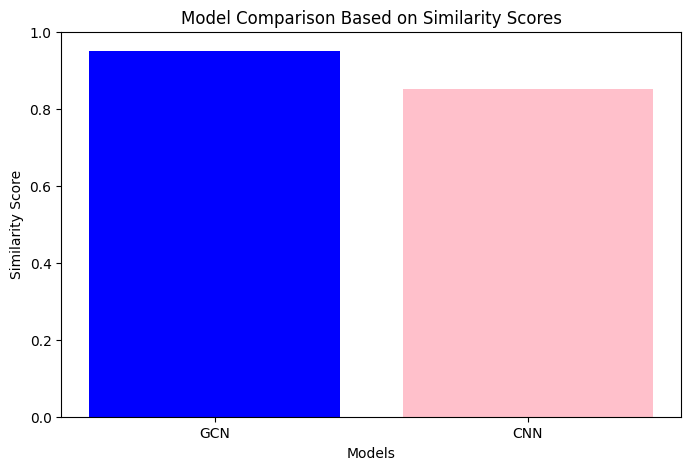

In [ ]:
import matplotlib.pyplot as plt
models = ['GCN', 'CNN']
similarity_scores = [0.95, 0.85]

# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, similarity_scores, color=['blue', 'pink'])

# Add title and labels
plt.title('Model Comparison Based on Similarity Scores')
plt.xlabel('Models')
plt.ylabel('Similarity Score')

# Display the plot
plt.ylim(0, 1)  # Ensure the y-axis goes from 0 to 1
plt.show()
